![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/1.3.Trasformer_based_Text_Recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

**Please choose GPU runtime**

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs==4.4.11

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=False
nlp.install(refresh_install=True, visual=True)

In [ ]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

In [ ]:
from johnsnowlabs import nlp, visual
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/4.4.4.spark_nlp_for_healthcare (3).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.4, 💊Spark-Healthcare==4.4.4, 🕶Spark-OCR==4.4.4, running on ⚡ PySpark==3.1.2


## Read image


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


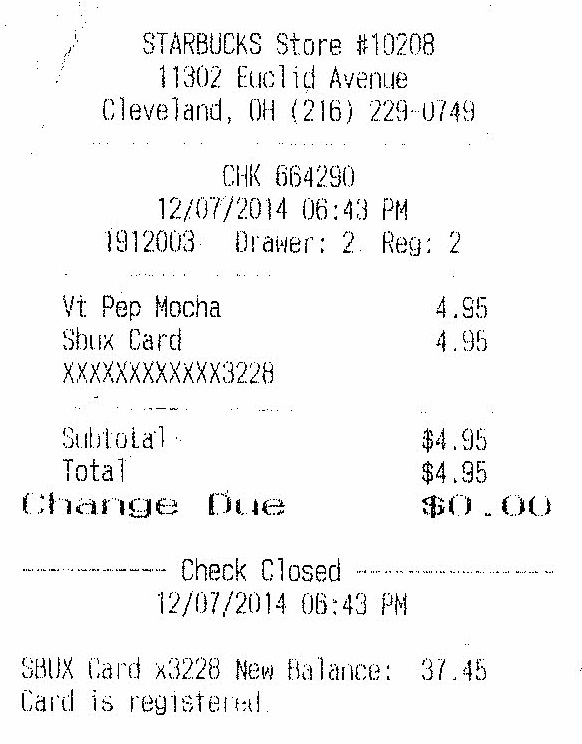

In [ ]:
image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path)
image_df = visual.BinaryToImage().transform(image_example_df).cache()

visual.display_images(image_df)

In [ ]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

text_detector = visual.ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

draw_regions = visual.ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(visual.Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

## Run pipeline and show results


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


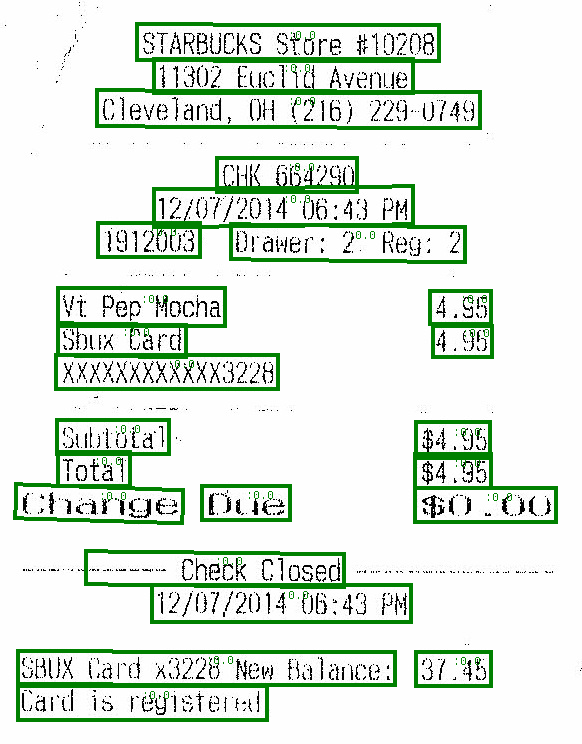

In [ ]:
result = pipeline.transform(image_example_df)
visual.display_images(result, "image_with_regions")

## Disable refiner and tune thresholds for detect each word separately


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


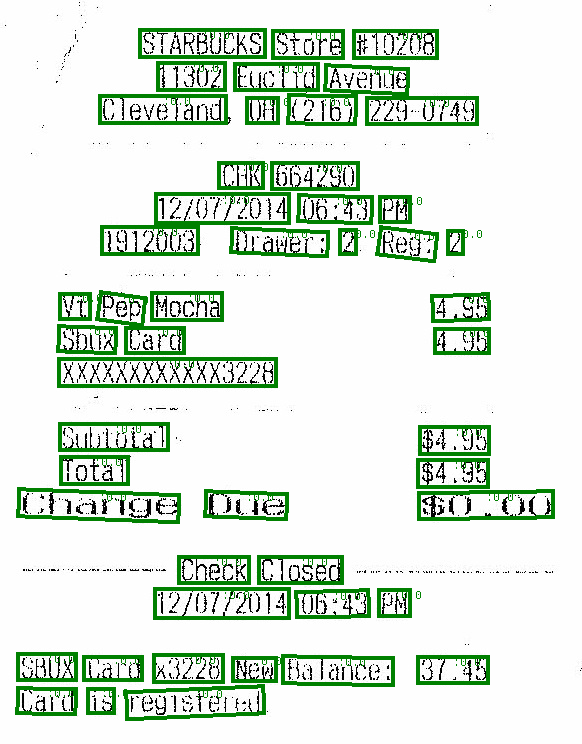

In [ ]:
pipeline.stages[1].setWithRefiner(False)
pipeline.stages[1].setSizeThreshold(15)
pipeline.stages[1].setLinkThreshold(0.3)
pipeline.stages[1].setScoreThreshold(0.7)
pipeline.stages[1].setTextThreshold(0.4)
pipeline.stages[1].setMergeIntersects(True)

result = pipeline.transform(image_example_df)
visual.display_images(result, "image_with_regions")

In [ ]:
from sparkocr.transformers import *

In [ ]:
ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
          .setRegionsColumn("text_regions")\
          .setInputCols(["image"]) \
          .setOutputCol("text") \
          .setOutputFormat(visual.OcrOutputFormat.TEXT) \
          .setLineTolerance(0) \
          .setGroupImages(False)

print(("").join([x.text for x in ocr.transform(result).select("text").collect()]))

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAWER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [ ]:
ocr_formatted = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions")\
    .setInputCols(["image"]) \
    .setOutputCol("text_formatted") \
    .setOutputFormat(visual.OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(True)

print(("").join([x.text_formatted for x in ocr_formatted.transform(result).select("text_formatted").collect()]))

       STARBUCKS STORE #10208
       11302 EUCLID AVENUE
       CLEVELAND OH (216) 229-0749

       CHK 664290
       12/07/2014 06:43 PM
       1912003 DRAWER: 2 REG: 2

      VT PEP MOCHA 4.95
      SBUX CARD 4.95
    XXXXXXXXXXXX3228

      SUBTOTAL $4.95
      TOTAL $4.95
   CHANGE DUE $0.00

      CHECK CLOSED
       12/07/2014 06:43 PM

     SBUX CARD X3228 NEW BALANCE: 37.45
   CARD IS REGISTERED
